# Прогнозирование температуры звезды с помощью нейронных сетей



<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Описание проекта**    
Проект разрабатывается для обсерватории "Небо на ладони" с целью создания модели машинного обучения, способной предсказывать температуру на поверхности звезд по их характеристикам. Имеющиеся традиционные методы расчета температуры (закон смещения Вина, закон Стефана-Больцмана и спектральный анализ) требуют альтернативного решения для повышения точности измерений.

**Цель проекта**
Разработка нейронной сети, обеспечивающей прогнозирование абсолютной температуры звезды (в Кельвинах) с ошибкой RMSE не более 4500.

**Задачи проекта**    
    
1. **Анализ и подготовка данных**
   - Исследование распределения признаков
   - Обработка пропусков и выбросов
   - Нормализация числовых признаков
   - Кодирование категориальных переменных
   

2. **Построение базовой модели**
   - Разработка архитектуры нейросети
   - Подбор гиперпараметров
   - Обучение и валидация модели
   

3. **Оптимизация модели**
   - Эксперименты с регуляризацией (Dropout)
   - Сравнение различных архитектур
   

4. **Оценка результатов**
   - Анализ метрик качества

   

**Данные**     
Используется датасет с характеристиками 240 звезд, включающий:
- Относительная светимость (L/Lo)
- Относительный радиус (R/Ro)
- Абсолютная звездная величина (Mv)
- Цвет звезды (категориальный)
- Тип звезды (категориальный)
- Абсолютная температура (T(K)) - целевая переменная

## Импорты и функции

In [1]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import random
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik


# Модели обучения
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 40

In [6]:
torch.manual_seed(1234)
input_size = 28*28
hidden_size = 800
num_classes = 10
num_epochs = 1
batch_size = 100
learning_rate = 0.001

### Функции

In [7]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [8]:
#Функция для отображения уникальных значений в категориальных данных для поиска неявных дубликатов
def category_hide_duplicates(df):
    
    # Получаем список категориальных столбцов
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    
    # Проходим по каждому категориальному столбцу
    for col in cat_col_names:
        print(f"{col}:")
        print(df[col].unique()) 
        print('КОЛИЧЕСТВО УНИКАЛЬНЫХ ЗНАЧЕНИЙ:', df[col].nunique()) 
        print('=' * 50) 

In [9]:
#Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.05  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [10]:
def search_сategory(df,col):
    
    ratio = round(df.groupby(col)[col].count()/df[col].count()*100)
    
    ratio.plot(
    kind = 'pie',
    autopct='%1.1f%%',
    labels = ratio.index,
    figsize=(6,6),
    title = 'Круговая диаграмма соотношения признаков в данных '+ col,
    ylabel = '',
    colors=sns.color_palette('pastel'),
    fontsize = 12
    )

In [11]:
def discrete_search_plot(df_col, title_name):

    plt.figure(figsize=(12, 8))
    sns.color_palette("crest", as_cmap=True)
    
    fig = sns.countplot(df_col, x = title_name, edgecolor='black')
    fig.set_title(title_name, fontsize=14)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Количество')
    fig.grid(True)



    plt.show()

In [12]:
def scatter_show(df):
    ### Создадим список  признаков 
    col = list(df.columns.drop('temperature'))

    # Построение диаграмм рассеяния
    plt.figure(figsize=(15, 20))

    for i, k in enumerate(col, 1):
        plt.subplot(4, 2, i)
        sns.scatterplot(
            data=df,
            y=k,
            x='temperature',
#            hue = name_of_feature,
            alpha=0.7
        )
        plt.title(f'Температура звезд, {k}')

    plt.show()

In [13]:
def comparation_bar(predict, bar=72):
    x = np.arange(bar)
    plt.figure(figsize = (15,8))
    plt.bar(x, predict[:bar], width = 0.6, color = 'orange', edgecolor = 'black', label='Предсказание', alpha=0.5)
    plt.bar(x, y_test[:bar], width = 0.3, color = 'skyblue', edgecolor = 'black', label='Действительное значение')
    plt.title('Сравнение предсказания и действительных температур')
    plt.ylabel('Температура звезды')
    plt.xlabel('Номер звезды')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

## Загрузка данных

In [14]:
try:
    df = pd.read_csv('/datasets/6_class.csv', sep =',')
except:
    df = pd.read_csv('6_class.csv', sep =',')

    
    
df_raw = df.shape[0]

In [15]:
show_info(df)

Количество строк выборки составляет: 240 



'Первые пять строк'

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


Количество явных дубликатов составляет 0


### Подытог загрузки данных

**Объем данных**:
- Выборка содержит 240 наблюдений (звезд)
- Пропуски и дубликаты отсутствуют

**Ключевые характеристики**:

- Температура, светимость и радиус имеет большой разброс и стандартное отклонение. Для эффективног о обучения необходимо отмасштабировать данные. Также можно попробовать создать новые признаки через логарифмирование

**Категориальные признаки:**
  - 6 типов звезд (кодированы числами 0-5) --> перевести в категориальный признак т.к. тип звезды неисчеслим
  - цвет звезды  --> проверить на скрытые дубликаты


Столбец `Unnamed: 0` Можно поставить индексом или удалить.

## Предобработка и анализ данных

In [16]:
df = df.set_index('Unnamed: 0')

In [17]:
# Переименую колонки для удобства в работе
df.columns = ['temperature', 'luminosity', 'radius','mv', 'star_type', 'star_color']

In [18]:
df['star_type'] = df['star_type'].astype('object')

### Скрытые дубликаты

In [19]:
category_hide_duplicates(df)

star_type:
[0 1 2 3 4 5]
КОЛИЧЕСТВО УНИКАЛЬНЫХ ЗНАЧЕНИЙ: 6
star_color:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
КОЛИЧЕСТВО УНИКАЛЬНЫХ ЗНАЧЕНИЙ: 19


Заметны скрытые дубликаты в цветах звезд. Приведем в порядок

In [20]:
df['star_color'] = (df['star_color']
                    .str.lower()
                    .str.strip()
                    .str.replace(r'[\s-]+', '-', regex=True)
                   )



In [21]:
color_mapping = {
    'yellowish-white': 'yellow-white',
    'white-yellow': 'yellow-white',
    'pale-yellow-orange': 'orange-yellow',
    'whitish': 'white',
    'yellowish': 'yellow',
}
df['star_color'] = df['star_color'].replace(color_mapping)

In [22]:
category_hide_duplicates(df)

star_type:
[0 1 2 3 4 5]
КОЛИЧЕСТВО УНИКАЛЬНЫХ ЗНАЧЕНИЙ: 6
star_color:
['red' 'blue-white' 'white' 'yellow-white' 'orange-yellow' 'blue' 'orange'
 'yellow' 'orange-red']
КОЛИЧЕСТВО УНИКАЛЬНЫХ ЗНАЧЕНИЙ: 9


Скрытые дубликаты отсутствуют

In [23]:
df['star_color'].value_counts()

red              112
blue              56
blue-white        41
white             12
yellow-white      12
yellow             3
orange             2
orange-yellow      1
orange-red         1
Name: star_color, dtype: int64

In [24]:
color_mapping_2 = {
#    'yellow': 'other',
    'orange-yellow': 'orange',
#    'orange': 'other',
    'orange-red': 'orange',
#    'white':'other',
#    'yellow-white':'other'
}
df['star_color'] = df['star_color'].replace(color_mapping_2)

In [25]:
df['star_color'].value_counts()

red             112
blue             56
blue-white       41
white            12
yellow-white     12
orange            4
yellow            3
Name: star_color, dtype: int64

создадим новые признаки, прологарифмированные значения светимости и радиуса

In [26]:
cols_to_log = ['luminosity', 'radius']
for col in cols_to_log:
    df[f'log_{col}'] = np.log(df[col])

### Исследовтельский анализ

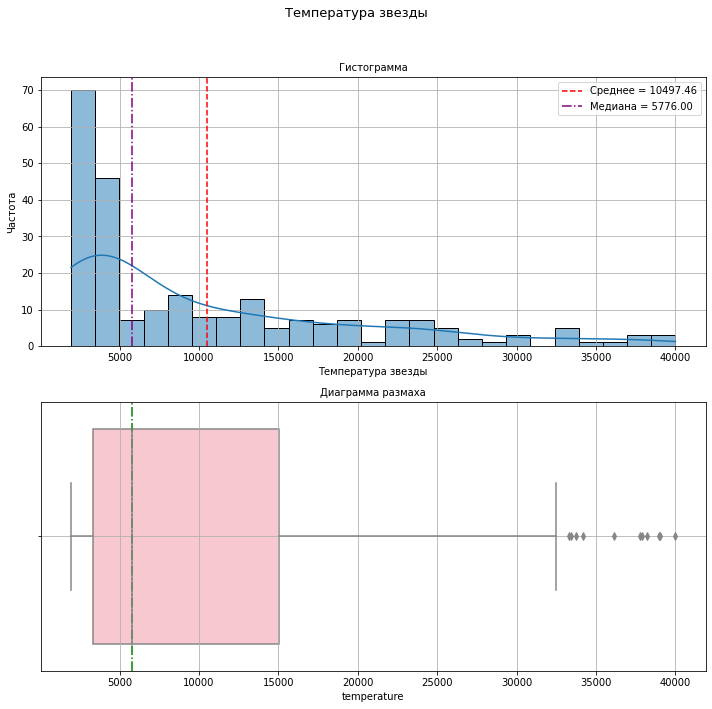

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [27]:
search_plot(df['temperature'],'Температура звезды',25)

Данные распределены неравномерно и есть выбросы со звездами с большой температурой.
Обрезать данные не будем, так как их и так очень мало

---

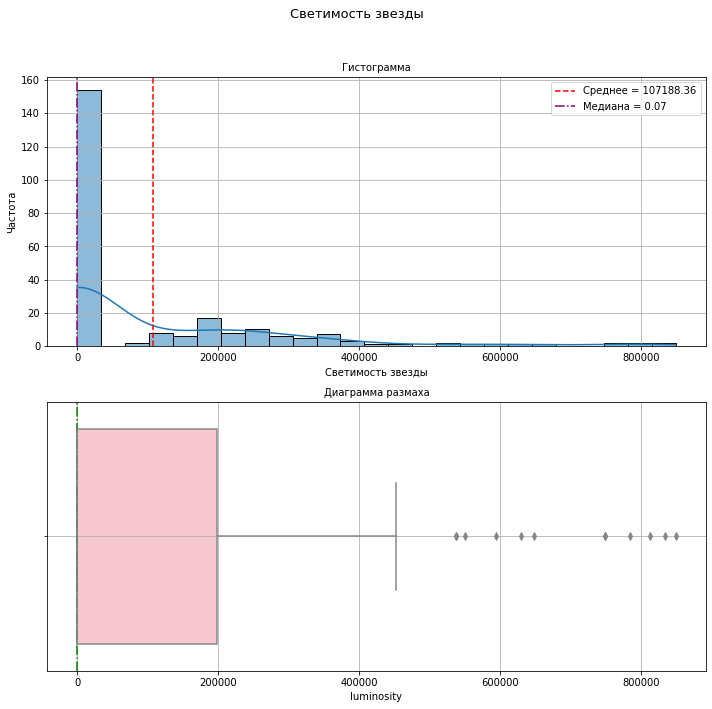

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [28]:
search_plot(df['luminosity'],'Светимость звезды',25)

Со светимостью такая же проблема, как и в предыдущем пункте

----

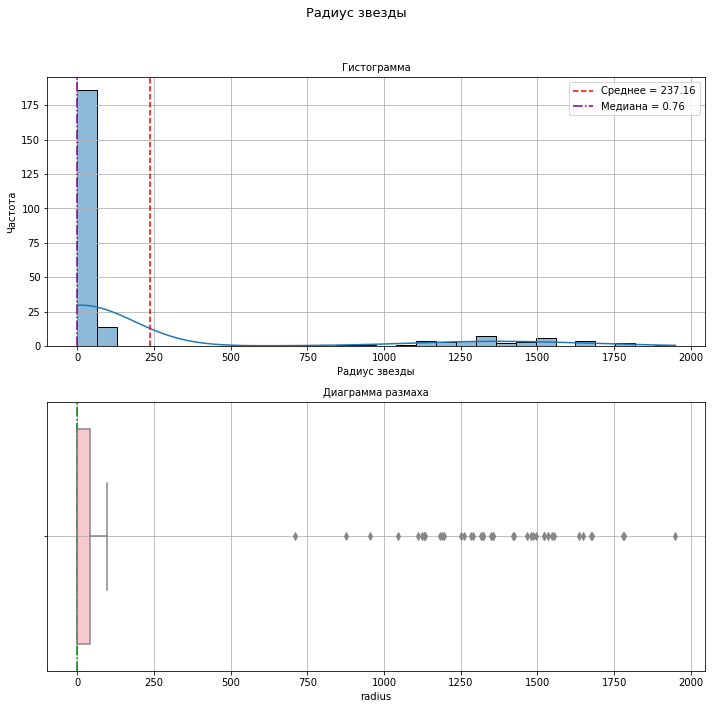

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [29]:
search_plot(df['radius'],'Радиус звезды',30)

Выбросы наблюдаются и здесь, но такие размеры имеют место быть, удалять не будем

---

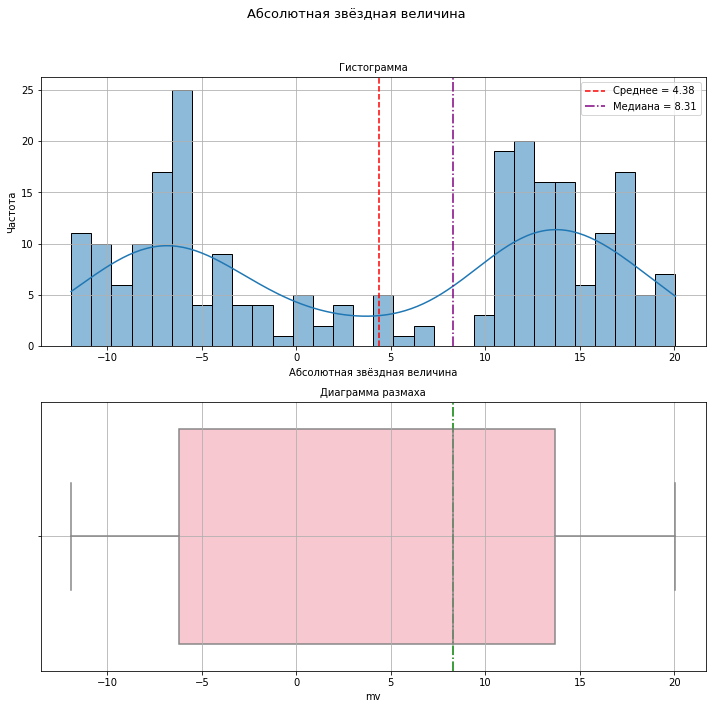

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: mv, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [30]:
search_plot(df['mv'],'Абсолютная звёздная величина',30)

Здесь данные распределены равномернее, чем в предыдущих пунктах. Можно отметить, что на графике двух вершинное распределение

---

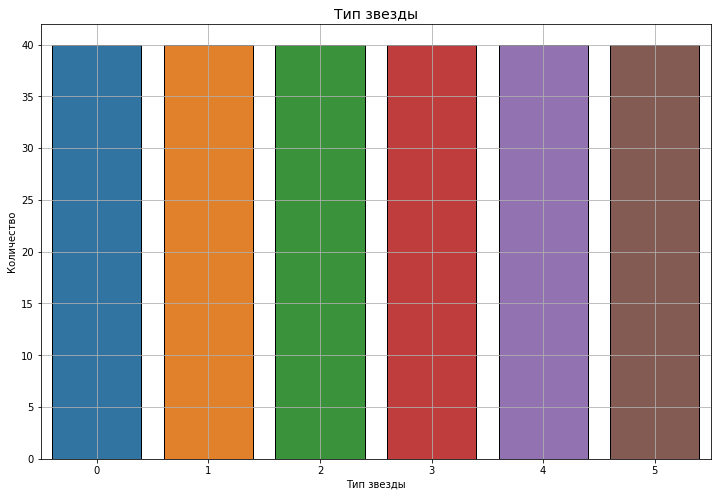

In [31]:
discrete_search_plot(df['star_type'].astype(int),'Тип звезды')

В выборке тип звезды сбалансирован

----

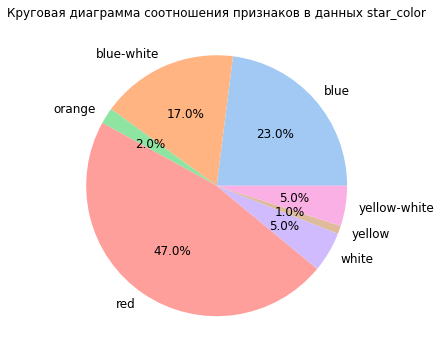

In [32]:
search_сategory(df,'star_color')

Мажорный класс цвета является красным, остальная половина выборки распределена между тремя цветами. При подготовке данных будем стратифицировать данный признак для лучшего обучения модели

---

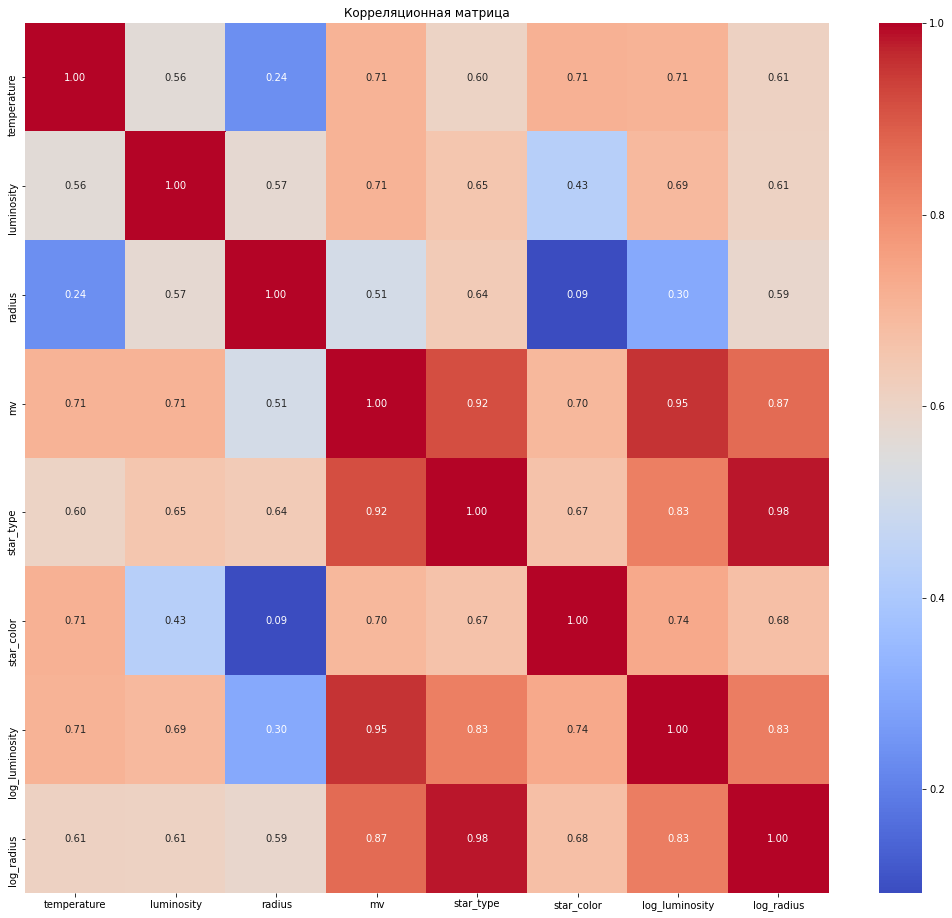

In [33]:
phik_matrix = (
    df
    .phik_matrix(interval_cols=df.select_dtypes(include='number')
    .columns.tolist())
)

plt.figure(figsize=(18, 16))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Наиболее коррелируемые с целевым признаком оказались(>0.7):   
1) цвет звезды    
2) абсолютная звёздная величина    
3) логарифмированные значения светимости    

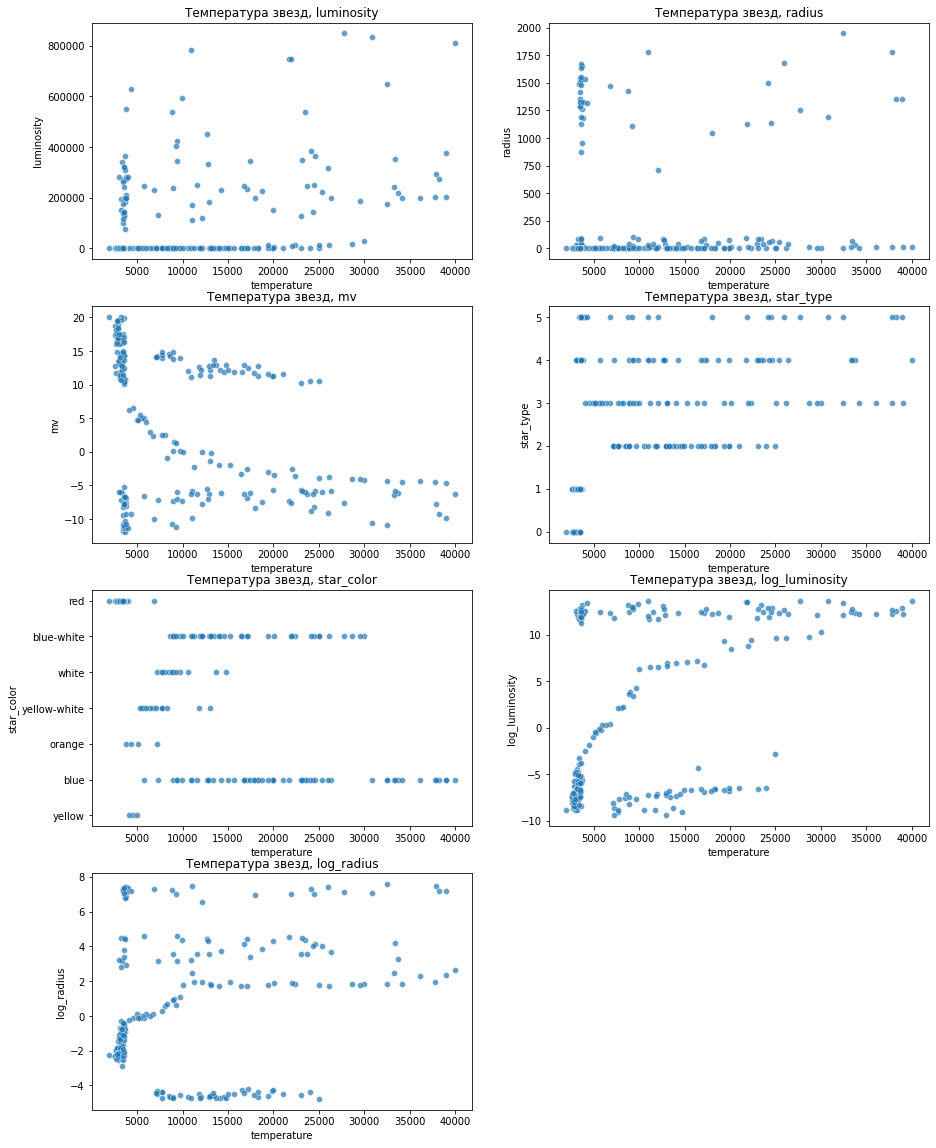

In [34]:
scatter_show(df)

Зависимость между параметрами и целевой переменной   
1) **Цвет звезды:**
- красный и желтый имееют низкие температуры по сранению с остальными звездами
- синие звезды самые горячие, но имеюю большой диапазон разброса (от 5К до 40К)
- белые и желтые звезды в диапазоне от 5 до 30 К    

2) **Тип звезды:**     
- коричневый карлик и красный карлик самые низкие по температуре звезды 

3) **Светимость и радиус:**
- сами по себе значения не дают четкого представления зависимости от целевой переменной
- прологарифмированные значения выделили на кластеры и можно сказать, что с log-radius выше 1 звезды распределены с температурой до 40 К. (-3,1) до 10 К, -3 и ниже от 7К до 25К
- самые горячие звезды имеют высокую светимость    

4) **Абсолютная звёздная величина:**   
- самые горячие звезды имеют значения от -10 до 0

## Подготовка данных

In [35]:
df_train = df.copy()

In [36]:
df_train.head()

,temperature,luminosity,radius,mv,star_type,star_color,log_luminosity,log_radius
Unnamed: 0,,,,,,,,
0,3068,0.002400,0.1700,16.12,0,red,-6.032287,-1.771957
1,3042,0.000500,0.1542,16.60,0,red,-7.600902,-1.869505
2,2600,0.000300,0.1020,18.70,0,red,-8.111728,-2.282782
3,2800,0.000200,0.1600,16.65,0,red,-8.517193,-1.832581
4,1939,0.000138,0.1030,20.06,0,red,-8.888257,-2.273026


In [37]:
num_cols = ['luminosity', 'radius', 'mv','log_luminosity','log_radius']
for col in num_cols:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    df_train[col] = pt.fit_transform(df[[col]])

In [38]:
X, y = df_train.drop('temperature',axis=1), df_train['temperature']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1, 
    random_state = RANDOM_STATE,
    shuffle=True,
    stratify = X['star_color']
)

In [40]:
test_num = y_test.shape[0]
print('Размер тестовой выборки:',test_num)

Размер тестовой выборки: 24


In [41]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()

In [42]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False)
        )
    ]
)

In [43]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)

In [44]:
# Масштабируем количественнык данные
data_preprocessor.fit(X_train)

X_train = data_preprocessor.transform(X_train)
X_test = data_preprocessor.transform(X_test)

In [45]:
# Преобразуем данные в тензоры
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

Был выбран размер батча равный единице, так как с увеличением предсказания ухудшались. Проблема в маленькой выборке датасета и ненормальным распределении данных

In [46]:
input_size = X_train.shape[1]  
hidden_size1 = 187
hidden_size2 = 194
hidden_size3 = 127
hidden_size4 = 253
output_size = 1
batch_size = 1
learning_rate = 0.001
num_epochs = 30

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.use_deterministic_algorithms(True)

In [47]:
# 3. Определение модели с ПРАВИЛЬНЫМИ размерностями
class StarTemperaturePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StarTemperaturePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size1)  # Используем input_dim
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size4, output_size)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

In [48]:
model = StarTemperaturePredictor(input_size)
#Проверяем архитектуру модели
print("\nАрхитектура модели:")
print(model)


Архитектура модели:
StarTemperaturePredictor(
  (fc1): Linear(in_features=16, out_features=187, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=187, out_features=194, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=194, out_features=127, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=127, out_features=253, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=253, out_features=1, bias=True)
)


In [49]:
# 6. Обучение модели
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("\nНачало обучения...")
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Перемешиваем данные каждый эпох
    permutation = torch.randperm(X_train.size(0))
    
    for i in range(0, X_train.size(0), batch_size):
        # Получаем батч
        indices = permutation[i:i+batch_size]
        X_batch = X_train[indices]
        y_batch = y_train[indices]
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        preds = model(X_batch)
        
        # Вычисление потерь
        loss = criterion(preds, y_batch)
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Сохраняем train loss
    avg_train_loss = total_loss / len(X_train)
    train_losses.append(avg_train_loss)
    
    with torch.no_grad():
        test_preds = model(X_test)
        rmse = mean_squared_error(y_test, test_preds.numpy())**0.5
        test_losses.append(rmse**2)
    
    # Валидация
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            rmse = mean_squared_error(y_test, test_preds.numpy())**0.5
            
            print(f'Epoch {epoch:3d} | Loss: {total_loss/len(X_train):.4f} | Test RMSE: {rmse:.2f}')


Начало обучения...
Epoch   0 | Loss: 110747968.8563 | Test RMSE: 7706.96
Epoch  10 | Loss: 20410446.2992 | Test RMSE: 4833.07
Epoch  20 | Loss: 17417943.3602 | Test RMSE: 4246.79
Epoch  29 | Loss: 16103403.5514 | Test RMSE: 3919.61


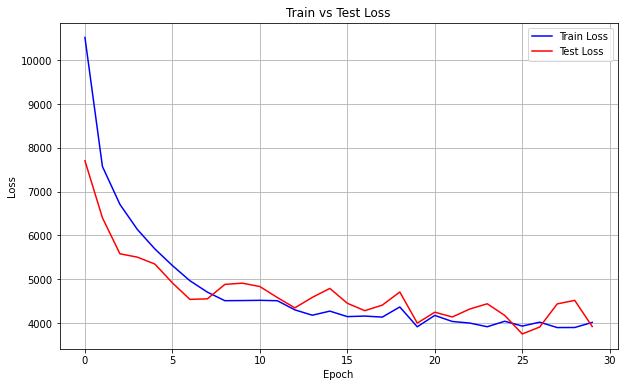

In [50]:
train_losses_sqrt = [x**0.5 for x in train_losses]
test_losses_sqrt = [x**0.5 for x in test_losses]
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(train_losses_sqrt, label='Train Loss', color='blue')
plt.plot(test_losses_sqrt, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Хорошее начальное обучение: и train, и test loss резко снижаются в первые эпохи

Тестовая ошибка ниже тренировочной:
Это может быть связано с небольшим размером тестовой выборки или с тем, что тестовые данные менее сложные.

Отсутствие явного переобучения:
Тестовая ошибка не начинает расти после достижения минимума, а скорее колеблется, что говорит о том, что модель не сильно переобучается.

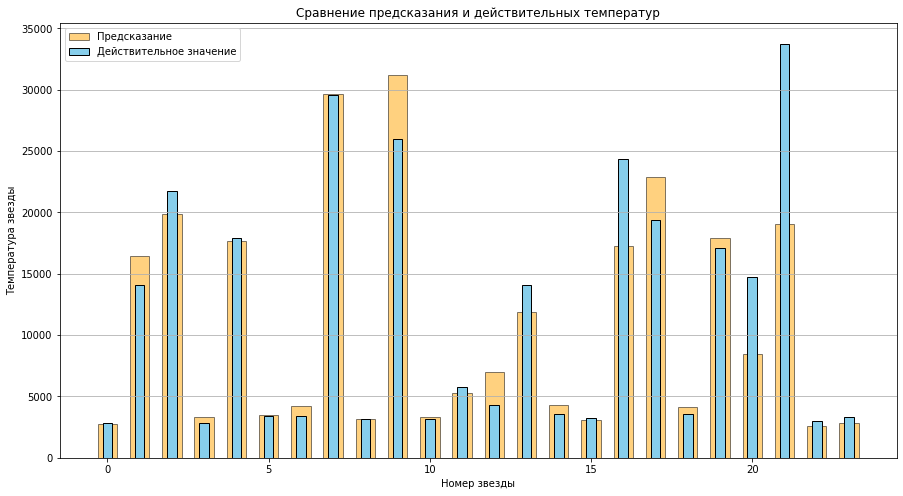

In [51]:
comparation_bar(test_preds.data.flatten(),bar=test_num)

Для большинства звезд предсказанные значения примерно соответствуют реальным.
Ошибки возникают на звездах с высокой температурой(от 10к и выше).

## Улучшение нейронной сети

Так как размер батча равен единице, то поробую улучшить модель с помощью dropout

In [52]:
class StarTemperaturePredictorTuning(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.3):
        super(StarTemperaturePredictorTuning, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_prob)
        
        self.fc5 = nn.Linear(hidden_size4, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x

In [53]:
model_2 = StarTemperaturePredictorTuning(input_size, dropout_prob=0.1)

In [54]:
# Обучение модели
criterion = nn.MSELoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

print("\nНачало обучения...")
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model_2.train()
    total_loss = 0
    
    # Перемешиваем данные каждый эпох
    permutation = torch.randperm(X_train.size(0))
    
    for i in range(0, X_train.size(0), batch_size):
        # Получаем батч
        indices = permutation[i:i+batch_size]
        X_batch = X_train[indices]
        y_batch = y_train[indices]
        
        # Обнуляем градиенты
        optimizer_2.zero_grad()
        
        # Прямой проход
        preds = model_2(X_batch)
        
        # Вычисление потерь
        loss = criterion(preds, y_batch)
        
        # Обратный проход
        loss.backward()
        optimizer_2.step()
        
        total_loss += loss.item()
        
    # Сохраняем train loss для графика
    avg_train_loss = total_loss / len(X_train)
    train_losses.append(avg_train_loss)
    
    # Сохраняем test loss для графика
    with torch.no_grad():
        test_preds = model_2(X_test)
        rmse = mean_squared_error(y_test, test_preds.numpy())**0.5
        test_losses.append(rmse**2)
    
    
    # Валидация
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        model_2.eval()
        with torch.no_grad():
            test_preds_2 = model_2(X_test)
            rmse = mean_squared_error(y_test, test_preds_2.numpy())**0.5
            print(f'Epoch {epoch:3d} | Loss: {total_loss/len(X_train):.4f} | Test RMSE: {rmse:.2f}')
              


Начало обучения...
Epoch   0 | Loss: 119514069.3339 | Test RMSE: 8076.06
Epoch  10 | Loss: 20679646.2142 | Test RMSE: 4414.94
Epoch  20 | Loss: 18233047.9555 | Test RMSE: 4234.94
Epoch  29 | Loss: 18330389.2040 | Test RMSE: 4660.49


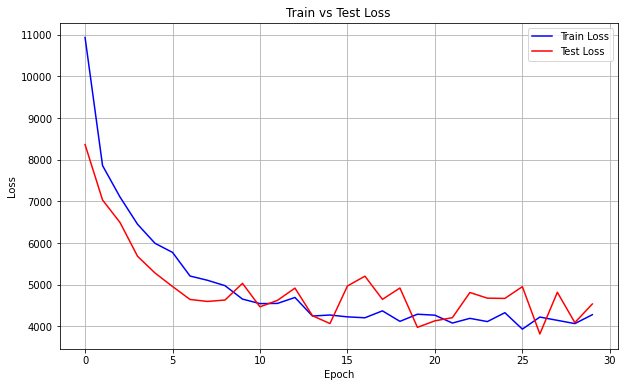

In [55]:
train_losses_sqrt = [x**0.5 for x in train_losses]
test_losses_sqrt = [x**0.5 for x in test_losses]
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(train_losses_sqrt, label='Train Loss', color='blue')
plt.plot(test_losses_sqrt, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

По сравнению с прошлым графиком явно заметно, что на тесте результаты менее стабильные и разброс амплитуднее

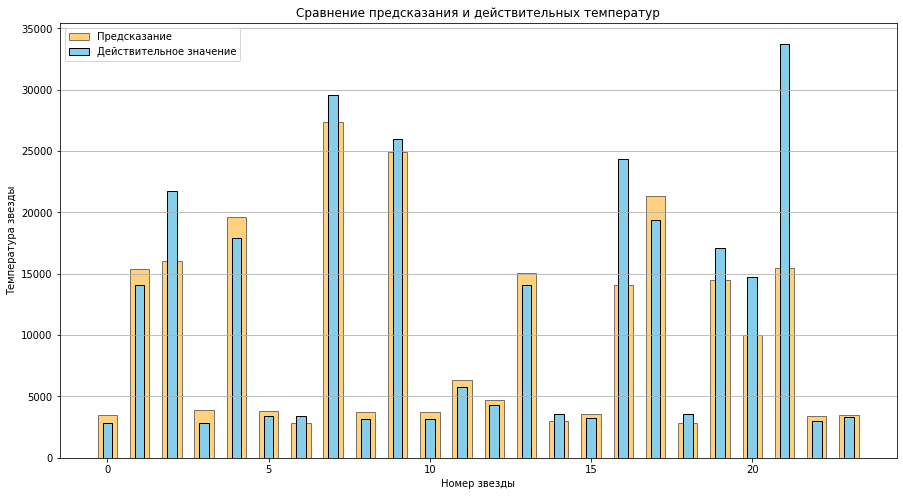

In [56]:
comparation_bar(test_preds_2.data.flatten(),bar=test_num)

Аналогичная ситуация. Ошибки возникают на звездах с высокой температурой. На звездах с низкой темпераурой ошибки очень маленькие

## Выводы

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

  
1. **Был проведен анализ и подготовка данных**:
   - выборка очень маленькая 
   - данные имеют выбросы
   - пропуски отстуствуют
   - устранены неявные дубликаты, и укрупнен признак цвета звезды
   

2. **Построена базовой модель нейронной сети**
   - Нейросеть имеет 4 скрытых слоя
   - Размер батча равен 1, 30 эпох
   - Метрики на тесте составили **RMSE: 3919**
   

3. **Оптимизация модели**   
   - Выставлена регуляризацией (Dropout = 0.1)  
   - Метрики на тесте составили **RMSE: 4660**  
   - График на train/test loss стал более амлитудный  
   

4. **Итог**   
Лучшей моделью стала базовая. Данная модель выполнила задание и показала RMSE меньше 4500.     
По графику сравнений предсказаний можно сделать вывод, что модель ошибается на выбросах, где значения температуры очень высокие. Улучшить модель можно, увеличив размерность датасета    

   
